In [1]:
from keras.preprocessing.image import load_img,img_to_array
import numpy  as np
from keras.applications import vgg19
import matplotlib.pyplot as plt
%matplotlib inline

content_img_path='leaf.jpeg'
style_img_path='the-great-wave-off-kanagawa.jpg'


Using TensorFlow backend.


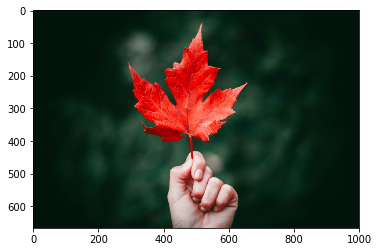

In [2]:
img=load_img(content_img_path)
plt.imshow(img)


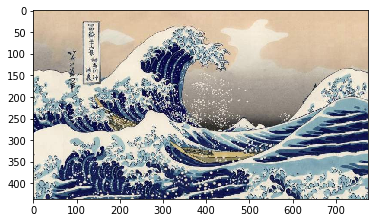

In [3]:
img=load_img(style_img_path)
plt.imshow(img)

In [4]:
def preprocess_img(img_path):
    
    img=load_img(img_path)
    width,height=img.size
    
    im_height_n=400

    im_width_n=int(width*im_height_n/height)
    desired_width, desired_height = 400, 400
    
    img = img.resize((im_width_n, im_height_n))
    #img=img_to_array(img)
    #img = array_to_img(img, scale=False)
    #plt.imshow(img)
    #plt.show()
    if im_width_n < desired_width:
        desired_width = im_width_n
    start_x = np.maximum(0, int(im_width_n-desired_width)/2)
    start_y= np.maximum(0, int(im_height_n-desired_height)/2)

    img = img.crop((start_x, start_y, start_x+desired_width, start_y+desired_height))
    #plt.imshow(img)
    #plt.show()
    img = img.resize((400, 400))
    plt.imshow(img)
    plt.show()

    img = img_to_array(img)
    
    print(img.size)
    img=np.expand_dims(img,axis=0)  #add one dimension to get 1,width,height for batch size
    img=vgg19.preprocess_input(img)
    return img


# mode: One of "caffe", "tf". - caffe: will convert the images from RGB to BGR, then will zero-center each color channel
# with respect to the ImageNet dataset, without scaling. - tf: will scale pixels between -1 and 1, sample-wise.

In [5]:
def unprocess_img(img):
    #mean = [103.939, 116.779, 123.68]
    
    img[:,:,0] +=103.939
    img[:,:,1] +=116.779
    img[:,:,2] +=123.68
    
    # convert back from RGB to BGR
    img=img[:,:,::-1]
    img=np.clip(img,0,255).astype('uint8')
    return img


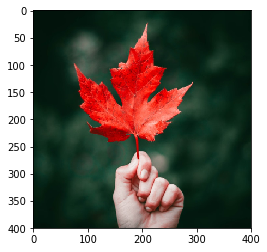

480000


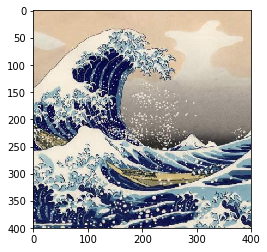

480000


In [6]:
from keras import backend as K

content_image=K.constant(preprocess_img(content_img_path))
style_image=K.constant(preprocess_img(style_img_path))

(im_height,im_width)=(400,400)
generated_image=K.placeholder((1,im_height,im_width,3),name='generate_placeholder')  # 1*400*400*3


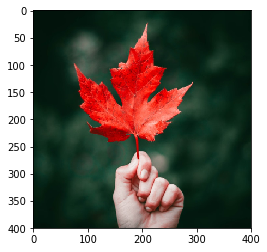

480000


160000

In [7]:
a=preprocess_img(content_img_path)
a[0,:,:,0].size #400*400

In [8]:
input_tensor=K.concatenate([content_image,style_image,generated_image],axis=0)


In [9]:
model=vgg19.VGG19(input_tensor=input_tensor,include_top=False,weights='imagenet')

In [10]:
def content_loss(content,generate):
    
    return K.sum(K.square(content-generate))

In [11]:
def style_loss(style,generate):
    
    S_gram=gram_matrix(style)
    G_gram=gram_matrix(generate)
    
    channel=3
    size=im_height*im_width
    
    return K.sum(K.square(S_gram-G_gram))/(4.0*(channel**2.0)*(size**2.0))   #normalize to input

In [12]:
def gram_matrix(input_matrix):
    
    feature=K.batch_flatten(K.permute_dimensions(input_matrix,(2,0,1)))  #dictate order of dimension to be transposed 
    return K.dot(feature,K.transpose(feature))
    

In [13]:
def variation_loss(generate):  #0:<399  (0<=388) - 1:<400 (1<=399) substract x and y direction separately from iteself 
                            # with a shift to remove blurr, and sharp pixel, per batch and color channel
    
    a=K.square(generate[:,:im_height-1,:im_width-1,:]-generate[:,1:,:im_width-1,:])
    b=K.square(generate[:,:im_height-1,:im_width-1,:]-generate[:,:im_height-1,1:,:])
    
    return K.sum(K.pow(a+b,1.25))

In [14]:
output_dict=  dict([(layer.name,layer.output)  for layer in model.layers])

In [15]:
print(output_dict)

{'input_1': <tf.Tensor 'concat:0' shape=(3, 400, 400, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 400, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 400, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 200, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 200, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 200, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 100, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'b

In [16]:
output_dict_2=  dict([(layer.__class__,layer.output)  for layer in model.layers])

In [17]:
print(output_dict_2)

{<class 'keras.engine.input_layer.InputLayer'>: <tf.Tensor 'concat:0' shape=(3, 400, 400, 3) dtype=float32>, <class 'keras.layers.convolutional.Conv2D'>: <tf.Tensor 'block5_conv4/Relu:0' shape=(3, 25, 25, 512) dtype=float32>, <class 'keras.layers.pooling.MaxPooling2D'>: <tf.Tensor 'block5_pool/MaxPool:0' shape=(3, 12, 12, 512) dtype=float32>}


In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [19]:
content_layer='block5_conv2'
style_layer=['block1_conv1','block1_conv2','block2_conv1','block2_conv2','block3_conv1','block3_conv2','block4_conv1','block4_conv2','block5_conv1','block5_conv2']

In [20]:
variation_weight=0.0001
style_weight=1.0
content_weight=0.002    #0.025

In [21]:
# loss update

loss=K.variable(0.0)

content_layer_feature=output_dict[content_layer]  #input of a network has three photo content_image,style_image,generated_image

content_feature=content_layer_feature[0,:,:,:] # content * width * height *filter
generate_feature=content_layer_feature[2,:,:,:] #generate * width * height *filter
loss += content_weight*content_loss(content_feature,generate_feature)   

for layer in style_layer:
    
    style_layer_feature=output_dict[layer]
    
    style_feature=style_layer_feature[1,:,:,:]
    generate_feature=style_layer_feature[2,:,:,:]
    
    
    loss +=style_weight*(style_loss(style_feature,generate_feature))/len(style_layer)
    
       
loss += variation_weight*variation_loss(generated_image) # this is not from network output but network input    


In [22]:
# create connections grad, input , loss

grads=K.gradients(loss,generated_image)[0]  #gradient respect to genertaae image
function_loss_grad=K.function([generated_image],[loss,grads])

In [23]:

class loss_grad_separate(object):
    
    def __init__(self):
        
        self.loss_value=None
        self.grad_value=None
        
    def loss(self,x):
        
        assert self.loss_value is None
        
        x=x.reshape((1,im_height,im_width,3)) #reshpae generate image
        out=function_loss_grad([x])
        loss_value=out[0]
        grad_value=out[1].flatten().astype('float64')
        
        self.loss_value=loss_value
        self.grad_value=grad_value
        
        return self.loss_value
    
    
    def grad(self,x):
        
        assert self.loss_value is not None
        grad_value=np.copy(self.grad_value)
        
        self.loss_value=None
        self.grad_value=None
        
        return grad_value
        


In [24]:
loss_grad_separator=loss_grad_separate()

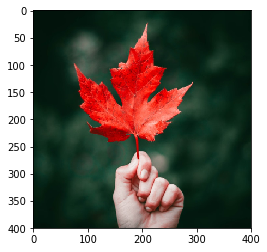

480000
start iteration: 0
current loss 7.1056e+09
start iteration: 1
current loss 3.32095e+09
start iteration: 2
current loss 1.89274e+09
start iteration: 3
current loss 1.20515e+09
start iteration: 4
current loss 8.08111e+08
start iteration: 5
current loss 5.79744e+08
start iteration: 6
current loss 4.50814e+08
start iteration: 7
current loss 3.69584e+08
start iteration: 8
current loss 3.12138e+08
start iteration: 9
current loss 2.68361e+08
start iteration: 10
current loss 2.36556e+08
start iteration: 11
current loss 2.0615e+08
start iteration: 12
current loss 1.85932e+08
start iteration: 13
current loss 1.67431e+08
start iteration: 14
current loss 1.54007e+08
start iteration: 15
current loss 1.44848e+08
start iteration: 16
current loss 1.34268e+08
start iteration: 17
current loss 1.26676e+08
start iteration: 18
current loss 1.20705e+08
start iteration: 19
current loss 1.15758e+08
start iteration: 20
current loss 1.10142e+08
start iteration: 21
current loss 1.05633e+08
start iteration

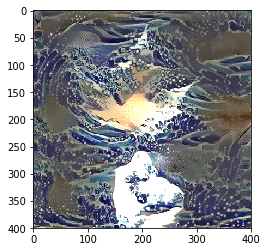

Image saved as my_result_at_iteration_49.png
Iteration 49 completed in 10s


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [25]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix='my_result'
iteration=50

x=preprocess_img(content_img_path) #start from content
x=x.flatten()

for i in range(iteration):
    
    print('start iteration:',i)
    start_time=time.time()
    
    x,min_val,info=fmin_l_bfgs_b(loss_grad_separator.loss,x,fprime=loss_grad_separator.grad,maxfun=20)
    
    print('current loss', min_val)
    
    img=x.copy().reshape((im_height,im_width,3))

    
    img=unprocess_img(img)
    
    if(i==iteration-1):

        plt.imshow(img)
        plt.show()

        fname=result_prefix+'_at_iteration_%d.png' % i
        imsave(fname,img)
        print('Image saved as', fname)
        end_time=time.time()
        print('Iteration %d completed in %ds' % (i,end_time-start_time))

